In [40]:
# Importing required libraries

import os
import json
import gzip
import pandas as pd
from string import punctuation

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import matplotlib.pyplot as plt

from collections import defaultdict, Counter
from wordcloud import WordCloud

from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


In [41]:
### load the meta data

data = []
with gzip.open('meta_Luxury_Beauty.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))
    
# total length of list, this number equals total number of products
print(len(data))

# first row of the list
# print(data[0])

12299


In [42]:
# All products whose title includes a specified term
cands = []
cands2 = []
for d in data:
    if 'title' in d and 'eyeliner' in d['title'].lower():
        cands.append(d)
    if 'title' in d and 'eyeliner' in d['title'].lower():
        cands2.append(d)


# building asin set
cands_asin = set([d['asin'] for d in cands])
cands2_asin = set([d['asin'] for d in cands2])
len(cands_asin)

73

In [43]:
# Aligning products with reviews

reviews = defaultdict(list)
with open('Luxury_Beauty.json', 'r') as f:
    for l in f:
        r = json.loads(l)
        a = r['asin']
        if a in cands_asin:
            reviews[a].append(r)

In [44]:
# Combining columns from data with Luxury_Beauty.json
combined_data = []
for asin, reviews_list in reviews.items():
    for review in reviews_list:
        d = {
            'asin': asin,
            'brand': next((c['brand'] for c in cands if c['asin'] == asin), None),
            'rank': next((c['rank'] for c in cands if c['asin'] == asin), None),
        }
        d.update(review)
        combined_data.append(d)

df = pd.DataFrame(combined_data)

## Preprocessing

In [45]:
# Converting the 'reviewText' column to lowercase
df['reviewText'] = df['reviewText'].str.lower()

# Tokenizing the 'reviewText' into individual words
# nltk.download('punkt')  # Downloading the resource for tokenization
df['tokenized_review'] = df['reviewText'].apply(lambda text: word_tokenize(str(text)))

# Removing stopwords from the tokenized reviews
# nltk.download('stopwords')  # Downloading the stopwords
stop_words = set(stopwords.words('english')+ list(punctuation))
df['filtered_review'] = df['tokenized_review'].apply(lambda tokens: [word for word in tokens if word not in stop_words])

In [46]:
#Removing unnecessary columns
columns_drop = ['brand', 'image', 'vote']

df.drop(columns_drop, axis=1, inplace=True)

In [47]:
#Converting the data types

df['reviewTime'] = pd.to_datetime(df['reviewTime'])
df['unixReviewTime'] = pd.to_datetime(df['unixReviewTime'])

In [48]:
# Categorizing the reviews to 'positive', 'neutral', 'negative'

df['sentiment_category'] = pd.cut(df['overall'], bins=[0, 2.9, 3.1, 5], labels=['negative', 'neutral', 'positive'])

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2304 entries, 0 to 2303
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   asin                2304 non-null   object        
 1   rank                2304 non-null   object        
 2   overall             2304 non-null   float64       
 3   verified            2304 non-null   bool          
 4   reviewTime          2304 non-null   datetime64[ns]
 5   reviewerID          2304 non-null   object        
 6   style               1634 non-null   object        
 7   reviewerName        2304 non-null   object        
 8   reviewText          2302 non-null   object        
 9   summary             2304 non-null   object        
 10  unixReviewTime      2304 non-null   datetime64[ns]
 11  tokenized_review    2304 non-null   object        
 12  filtered_review     2304 non-null   object        
 13  sentiment_category  2304 non-null   category    

In [50]:
df.head(3)

,asin,rank,overall,verified,reviewTime,reviewerID,style,reviewerName,reviewText,summary,unixReviewTime,tokenized_review,filtered_review,sentiment_category
0,B0007PG81S,"899,508 in Beauty & Personal Care (",5.0,True,2015-01-15,A1NU5L9ULOE15J,{'Color:': ' Soft Blonde'},Lukie,i have been using elizabeth arden's brow shape...,... Elizabeth Arden's brow shaper for years an...,1970-01-01 00:00:01.421280000,"[i, have, been, using, elizabeth, arden, 's, b...","[using, elizabeth, arden, 's, brow, shaper, ye...",positive
1,B0007PG81S,"899,508 in Beauty & Personal Care (",4.0,True,2009-03-31,A80LMH519G9H6,{'Color:': ' Sable'},A. Sequeira,i bought this item because i have been using t...,Item great... delivered in pieces!,1970-01-01 00:00:01.238457600,"[i, bought, this, item, because, i, have, been...","[bought, item, using, product, years, love, pr...",positive
2,B0007PG81S,"899,508 in Beauty & Personal Care (",5.0,True,2017-08-02,A15VECY6L4VC5F,{'Color:': ' Brunette'},deal maker,excellent product,Five Stars,1970-01-01 00:00:01.501632000,"[excellent, product]","[excellent, product]",positive


## EDA

In [51]:
# Getting the number of reviews and statistics
num_reviews = len(df)
rating_stats = df['overall'].describe()

print("Number of reviews:", num_reviews)
print("Rating statistics:")
print(rating_stats)

Number of reviews: 2304
Rating statistics:
count    2304.000000
mean        3.976997
std         1.445159
min         1.000000
25%         3.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: overall, dtype: float64


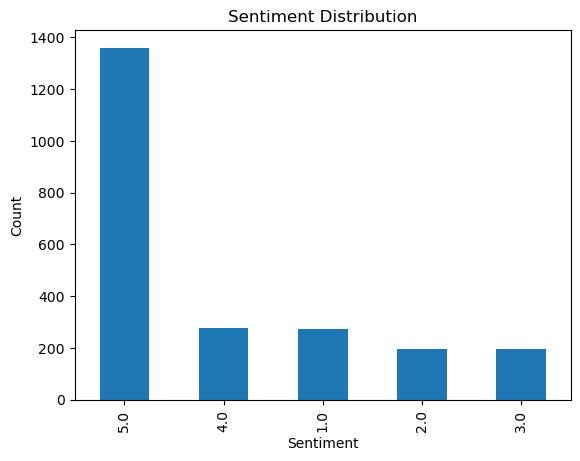

In [67]:
# Checking the distribution of ratings

sentiment_counts = df['overall'].value_counts()
sentiment_counts.plot(kind='bar')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()


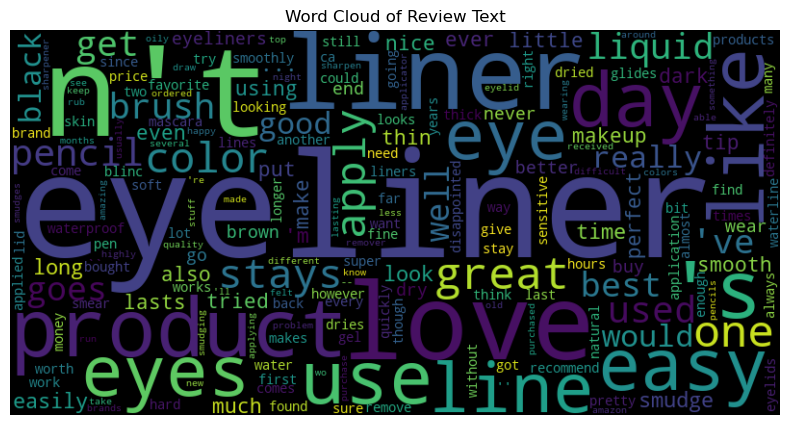

In [53]:
# Word Frequency analysis

words = [word for review in df['filtered_review'] for word in review]

# Counting word frequencies
word_frequencies = Counter(words)

# Generating and displaying word cloud
wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(word_frequencies)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Review Text')
plt.show()

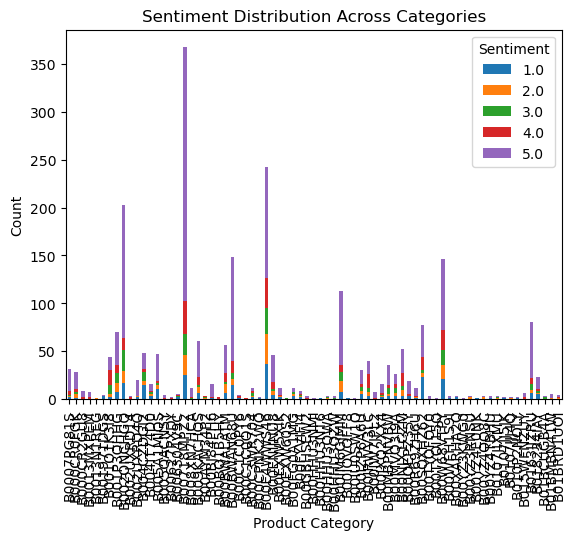

In [54]:
# Plotting sentiment distribution across product categories

category_sentiment_counts = df.groupby('asin')['overall'].value_counts().unstack()
category_sentiment_counts.plot(kind='bar', stacked=True)
plt.xlabel('Product Category')
plt.ylabel('Count')
plt.title('Sentiment Distribution Across Categories')
plt.legend(title='Sentiment')
plt.show()

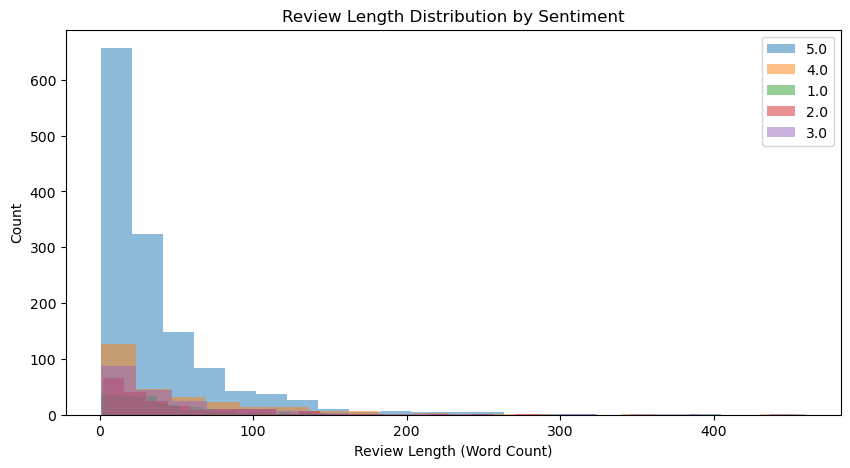

In [55]:
# Calculating review lengths (word count)
df['review_length'] = df['reviewText'].apply(lambda x: len(str(x).split()))

# Plotting review length distribution by sentiment
plt.figure(figsize=(10, 5))
for rating in df['overall'].unique():
    subset = df[df['overall'] == rating]
    plt.hist(subset['review_length'], bins=20, alpha=0.5, label=rating)
plt.xlabel('Review Length (Word Count)')
plt.ylabel('Count')
plt.title('Review Length Distribution by Sentiment')
plt.legend()
plt.show()


In [56]:
# Concatenating all tokenized reviews into a single list
all_reviews = [word for review in df['filtered_review'] for word in review]

# Calculate word frequency
word_freq = FreqDist(all_reviews)


## Model Building

In [57]:
# Splitting the data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42, stratify = df['sentiment_category'])

# Verifying the shape of train and test sets
print("Train set shape:", train_df.shape)
print("Test set shape:", test_df.shape)

Train set shape: (1612, 15)
Test set shape: (692, 15)


In [58]:
train_df['filtered_review'] = train_df['filtered_review'].apply(' '.join)
test_df['filtered_review'] = test_df['filtered_review'].apply(' '.join)

# feature matrix
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_df['filtered_review'])
X_test = vectorizer.transform(test_df['filtered_review'])

# target variable
y_train = train_df['sentiment_category']
y_test = test_df['sentiment_category']


### KNN

In [59]:
# Build and train the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Out of sample predictions
knn_predictions = knn_model.predict(X_test)

knn_accuracy = accuracy_score(y_test, knn_predictions)
print("KNN Accuracy:", knn_accuracy)

#In-sample predictions
knn_predictions = knn_model.predict(X_train)

knn_accuracy = accuracy_score(y_train, knn_predictions)
print("KNN Accuracy for in sample:", knn_accuracy)

KNN Accuracy: 0.7008670520231214
KNN Accuracy for in sample: 0.8312655086848635


### Naive Bayes

In [60]:
# Build and train the Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Out of sample predictions
nb_predictions = nb_model.predict(X_test)

nb_accuracy = accuracy_score(y_test, nb_predictions)
print("Naive Bayes Accuracy:", nb_accuracy)


# In-sample predictions
nb_predictions = nb_model.predict(X_train)

nb_accuracy = accuracy_score(y_train, nb_predictions)
print("Naive Bayes Accuracy for in sample:", nb_accuracy)

Naive Bayes Accuracy: 0.7225433526011561
Naive Bayes Accuracy for in sample: 0.7475186104218362


### SVM

In [61]:
# Build Support Vector Machine classifier
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)


# Out of sample predictions
svm_predictions = svm.predict(X_test)

accuracy_svm = accuracy_score(y_test, svm_predictions)
# precision_svm = precision_score(y_test, svm_predictions, average='weighted')
# recall_svm = recall_score(y_test, svm_predictions, average='weighted')
# f1_score_svm = f1_score(y_test, svm_predictions, average='weighted')
print("SVM Accuracy:", accuracy_svm)
# print("SVM Precision:", precision_svm)
# print("SVM Recall:", recall_svm)
# print("SVM F1 Score:", f1_score_svm)

# In-sample predictions
svm_predictions = svm.predict(X_train)

accuracy_svm = accuracy_score(y_train, svm_predictions)
# precision_svm = precision_score(y_train, svm_predictions, average='weighted')
# recall_svm = recall_score(y_train, svm_predictions, average='weighted')
# f1_score_svm = f1_score(y_train, svm_predictions, average='weighted')
print("SVM Accuracy for in sample:", accuracy_svm)

SVM Accuracy: 0.8179190751445087
SVM Accuracy for in sample: 0.9330024813895782


### Logistic Regression

In [62]:
# Build Logistic Regression classifier
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Out of sample predictions
logreg_predictions = logreg.predict(X_test)


accuracy_logreg = accuracy_score(y_test, logreg_predictions)
# precision_logreg = precision_score(y_test, logreg_predictions, average='weighted')
# recall_logreg = recall_score(y_test, logreg_predictions, average='weighted')
# f1_score_logreg = f1_score(y_test, logreg_predictions, average='weighted')
print("Logistic Regression Accuracy:", accuracy_logreg)

# In-sample predictions
logreg_predictions = logreg.predict(X_train)

accuracy_logreg = accuracy_score(y_train, logreg_predictions)
# precision_logreg = precision_score(y_train, logreg_predictions, average='weighted')
# recall_logreg = recall_score(y_train, logreg_predictions, average='weighted')
# f1_score_logreg = f1_score(y_train, logreg_predictions, average='weighted')
print("Logistic Regression Accuracy for in sample:", accuracy_logreg)

Logistic Regression Accuracy: 0.8034682080924855
Logistic Regression Accuracy for in sample: 0.8846153846153846
